In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Synthetic Data  ---
generate_synthetic_facies_data_for_comparison=pd.read_csv('synthetic_permeability__data_1000.csv')

In [25]:
# Generate the data and save to CSV
df = generate_synthetic_facies_data_for_comparison()
df.to_csv('synthetic_permeability__data_1000.csv', index=False)

In [26]:
# Generate the data
synthetic_facies_data = generate_synthetic_facies_data_for_comparison()
print("--- Original Synthetic Well Log Data with Facies (First 5 rows) ---")
print(synthetic_facies_data.head())
print("\n--- Facies Distribution ---")
print(synthetic_facies_data["Facies"].value_counts())

--- Original Synthetic Well Log Data with Facies (First 5 rows) ---
       Depth_m      GR_API  Resistivity_Ohm.m  Porosity_v/v  Facies
0  1000.000000   79.934283           0.908552      0.103704       0
1  1000.500501   67.234714           1.687438      0.108509       0
2  1001.001001   82.953771           0.677018      0.104446       0
3  1001.501502  100.460597           0.600404      0.125577       0
4  1002.002002   65.316933           0.758628      0.080954       0

--- Facies Distribution ---
Facies
0    400
1    300
2    300
Name: count, dtype: int64


In [27]:
# --- Rule-Based (Cutoff) Classification ---
print("\n--- Rule-Based (Cutoff) Classification ---")

# Define simple cutoffs (example: GR < 50 for Sand/Carbonate, GR >= 50 for Shale)
# This is a very simplified rule for demonstration.
predicted_facies_cutoff = np.zeros(len(synthetic_facies_data), dtype=int)
predicted_facies_cutoff[synthetic_facies_data["GR_API"] < 50] = 1  # Assume Sand/Carbonate

# For a more complex rule, we'll distinguish between all three facies
# Rule: 
# If GR > 60 -> Shale (0)
# Else if GR < 60 and Porosity > 0.18 -> Sandstone (1)
# Else -> Carbonate (2)
predicted_facies_cutoff_refined = np.zeros(len(synthetic_facies_data), dtype=int)  # Default to Shale

# Apply refined rules
sandstone_condition = (
    (synthetic_facies_data["GR_API"] < 60) & 
    (synthetic_facies_data["Porosity_v/v"] > 0.18)
)

carbonate_condition = (
    (synthetic_facies_data["GR_API"] < 60) & 
    (synthetic_facies_data["Porosity_v/v"] <= 0.18)
)

predicted_facies_cutoff_refined[sandstone_condition] = 1  # Sandstone
predicted_facies_cutoff_refined[carbonate_condition] = 2  # Carbonate

# Calculate accuracy
accuracy_cutoff = accuracy_score(synthetic_facies_data["Facies"],
                                predicted_facies_cutoff_refined)

print(f"Accuracy (Rule-Based Cutoff): {accuracy_cutoff:.2f}")
print("Classification Report (Rule-Based Cutoff):")
print(classification_report(synthetic_facies_data["Facies"],
                          predicted_facies_cutoff_refined, 
                          target_names=["Shale", "Sandstone", "Carbonate"]))


--- Rule-Based (Cutoff) Classification ---
Accuracy (Rule-Based Cutoff): 0.83
Classification Report (Rule-Based Cutoff):
              precision    recall  f1-score   support

       Shale       0.91      0.68      0.78       400
   Sandstone       0.96      0.99      0.97       300
   Carbonate       0.66      0.87      0.75       300

    accuracy                           0.83      1000
   macro avg       0.84      0.85      0.83      1000
weighted avg       0.85      0.83      0.83      1000



In [28]:
# --- Machine Learning (SVM) Classification ---
print("\n--- Machine Learning (SVM) Classification ---")
# Prepare data for ML
features = ["GR_API", "Resistivity_Ohm.m", "Porosity_v/v"]
X = synthetic_facies_data[features]
y = synthetic_facies_data["Facies"]


--- Machine Learning (SVM) Classification ---


In [29]:
# Scale features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.25,
random_state=42, stratify=y)

In [45]:
# Initialize and train a Support Vector Classifier (SVC)
model_svm = SVC(kernel='rbf', random_state=42) # RBF kernel for non-linear boundaries
model_svm.fit(X_train, y_train)
# Make predictions on the test set
y_pred_svm = model_svm.predict(X_test)
#'sigmoid', 'poly', 'rbf', 'precomputed', 'linear' # different Kernel methods

In [46]:
# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {accuracy_svm:.2f}")
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=["Shale",
"Sandstone", "Carbonate"]))

Accuracy (SVM): 1.00
Classification Report (SVM):
              precision    recall  f1-score   support

       Shale       1.00      1.00      1.00       100
   Sandstone       1.00      1.00      1.00        75
   Carbonate       1.00      1.00      1.00        75

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



nSaved facies classification comparison plot to facies_classification_comparison.png


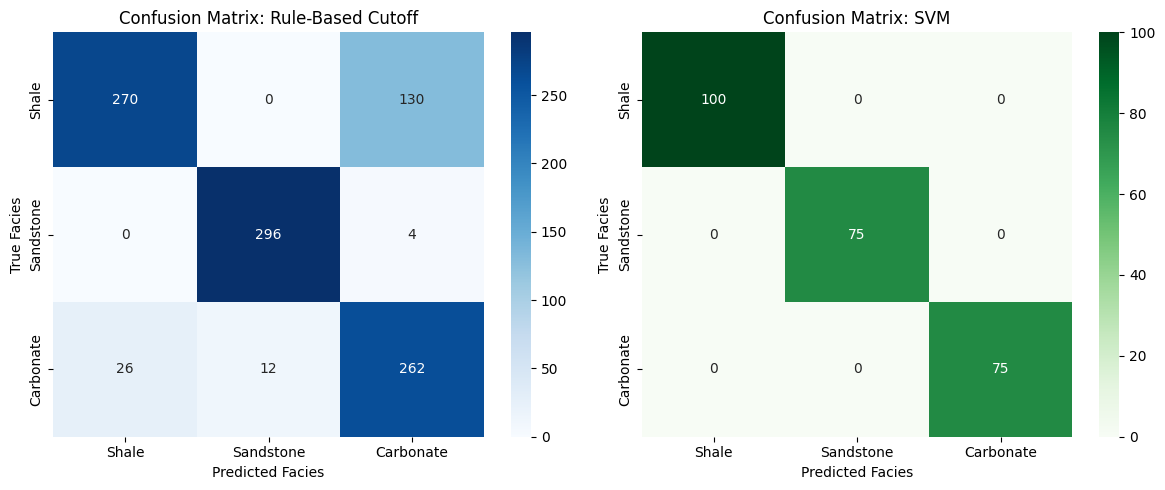

In [47]:
# --- Visualization of Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Confusion Matrix for Rule-Based
cm_cutoff = confusion_matrix(synthetic_facies_data["Facies"],
predicted_facies_cutoff_refined)
sns.heatmap(cm_cutoff, annot=True, fmt="d", cmap="Blues", ax=axes[0],
xticklabels=["Shale", "Sandstone", "Carbonate"],
yticklabels=["Shale", "Sandstone", "Carbonate"])
axes[0].set_title("Confusion Matrix: Rule-Based Cutoff")
axes[0].set_xlabel("Predicted Facies")
axes[0].set_ylabel("True Facies")
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", ax=axes[1],
xticklabels=["Shale", "Sandstone", "Carbonate"],
yticklabels=["Shale", "Sandstone", "Carbonate"])
axes[1].set_title("Confusion Matrix: SVM")
axes[1].set_xlabel("Predicted Facies")
axes[1].set_ylabel("True Facies")
plt.tight_layout()
# plt.show()
plt.savefig("facies_classification_comparison.png")
print("nSaved facies classification comparison plot to facies_classification_comparison.png")